In [1]:
##### IMPORT ALL PACKAGES #####
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from pandasql import sqldf
%matplotlib inline
pysqldf = lambda q: sqldf(q, globals())

##### IMPORT ALL DATA #####
df_imdb_name_basics = pd.read_csv('data/imdb.name.basics.csv')
df_imdb_title_akas = pd.read_csv('data/imdb.title.akas.csv')
df_imdb_title_basics = pd.read_csv('data/imdb.title.basics.csv') # PRIMARY
df_imdb_title_crew = pd.read_csv('data/imdb.title.crew.csv')
df_imdb_title_principals = pd.read_csv('data/imdb.title.principals.csv')
df_imdb_title_ratings = pd.read_csv('data/imdb.title.ratings.csv') # PRIMARY
df_rt_movie_info = pd.read_csv('data/rt.movie_info.tsv', delimiter = '\t')
df_rt_reviews = pd.read_csv('data/rt.reviews.tsv', delimiter = '\t', encoding= 'unicode_escape')
df_tmdb_movies = pd.read_csv('data/tmdb.movies.csv').drop('Unnamed: 0', axis=1)
df_tn_movie_budgets = pd.read_csv('data/tn.movie_budgets.csv')
df_tn_top_directors = pd.read_csv('data/tn.top_directors.csv', encoding= 'unicode_escape') #source: https://www.the-numbers.com/box-office-star-records/worldwide/lifetime-specific-technical-role/director

##### GENRES #####
GENRES_OG = ['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Game-Show', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi',
       'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
GENRES_FULL = [
     'genre_action','genre_adult','genre_adventure','genre_animation','genre_biography','genre_comedy','genre_crime',
     'genre_documentary','genre_drama','genre_family','genre_fantasy','genre_gameshow','genre_history','genre_horror',
     'genre_music','genre_musical','genre_mystery','genre_news','genre_reality_tv','genre_romance','genre_sci_fi',
     'genre_short','genre_sport','genre_talkshow','genre_thriller','genre_war','genre_western']
GENRE_CONVERSION = dict(zip(GENRES_FULL, GENRES_OG))

##### COMBINE AND CLEAN FINANCIAL DATA #####
df_money = df_tn_movie_budgets.loc[:, ['movie', 'production_budget', 'domestic_gross','worldwide_gross']].copy()
production_budget = [float(x.replace('$', '').replace(',','')) for x in df_money.production_budget] 
domestic_gross = [float(x.replace('$', '').replace(',','')) for x in df_money.domestic_gross]
worldwide_gross = [float(x.replace('$', '').replace(',','')) for x in df_money.worldwide_gross]
df_money = pd.DataFrame([production_budget, domestic_gross, worldwide_gross]).transpose()
df_money.columns = ['production_budget', 'domestic_gross', 'worldwide_gross']
df_money['profit'] = df_money.worldwide_gross - df_money.production_budget
df_money['movie'] = df_tn_movie_budgets.movie
df_money = df_money[['movie','production_budget', 'domestic_gross', 'worldwide_gross', 'profit']]
df_money = df_money.sort_values(by='movie').reset_index(drop=True)
df_genres = df_imdb_title_basics[df_imdb_title_basics['genres'].isna() == False].copy()
for category in GENRES_OG:
    df_genres[category] = [category in x for x in df_genres['genres']]
df_genres.drop(['start_year', 'runtime_minutes', 'genres', 'original_title'], axis=1, inplace=True)

##### CREATE FULL IMDB DB #####
df_imdb = pysqldf(''' SELECT * FROM df_imdb_title_basics basics
LEFT JOIN df_genres genres USING (tconst)
LEFT JOIN df_money money ON basics.primary_title == money.movie
LEFT JOIN df_tmdb_movies tmdb ON basics.primary_title == tmdb.original_title;''')

df_imdb = df_imdb[[
       'tconst', 'primary_title', 'original_title', 'start_year', 'runtime_minutes', 
       'production_budget', 'domestic_gross', 'worldwide_gross', 'profit',
       'genre_ids', 'id', 'original_language', 'popularity',
       'release_date', 'title', 'vote_average', 'vote_count',
       'Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Game-Show', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi',
       'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']]
df_imdb.columns = ['tconst', 'primary_title', 'DELETE1', 'original_title',
       'DELETE2', 'start_year', 'runtime_minutes', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'profit', 'genre_ids', 'id_tmdb',
       'original_language', 'popularity', 'release_date', 'title',
       'vote_average', 'vote_count', 'genre_action', 'genre_adult', 'genre_adventure',
       'genre_animation', 'genre_biography', 'genre_comedy', 'genre_crime', 'genre_documentary', 'genre_drama',
       'genre_family', 'genre_fantasy', 'genre_gameshow', 'genre_history', 'genre_horror', 'genre_music',
       'genre_musical', 'genre_mystery', 'genre_news', 'genre_reality_tv', 'genre_romance', 'genre_sci_fi',
       'genre_short', 'genre_sport', 'genre_talkshow', 'genre_thriller', 'genre_war', 'genre_western']
df_imdb.drop(['DELETE1', 'DELETE2'], axis=1, inplace=True)

In [2]:
df_rt_reviews

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"
...,...,...,...,...,...,...,...,...
54427,2000,The real charm of this trifle is the deadpan c...,NaN,fresh,Laura Sinagra,1,Village Voice,"September 24, 2002"
54428,2000,NaN,1/5,rotten,Michael Szymanski,0,Zap2it.com,"September 21, 2005"
54429,2000,NaN,2/5,rotten,Emanuel Levy,0,EmanuelLevy.Com,"July 17, 2005"
54430,2000,NaN,2.5/5,rotten,Christopher Null,0,Filmcritic.com,"September 7, 2003"


In [3]:
##### CLEANUPS #####
path = os.path.join('cleaning_dicts','cleaning_lookup_rt_studios.csv')
studio_cleanup_df = pd.read_csv(path)
STUDIO_CLEANUP_DICT = dict(zip(studio_cleanup_df.old, studio_cleanup_df.new))

path = os.path.join('cleaning_dicts','cleaning_lookup_rt_ratings.csv')
rating_cleanup_df = pd.read_csv(path)
RATING_CLEANUP_DICT = dict(zip(rating_cleanup_df.old, rating_cleanup_df.new))

df_rt_reviews['rating'] = df_rt_reviews['rating'].map(RATING_CLEANUP_DICT)
df_rt_reviews['fresh'] = df_rt_reviews['fresh'].map({'fresh':1, 'rotten':0}) #convert fresh/rotten text to binary 1/0
df_rt_reviews.drop(['review', 'publisher'], axis=1, inplace=True)
#df_rt_reviews.drop('publisher', axis=1, inplace=True)

In [4]:
df_rt_reviews

,id,rating,fresh,critic,top_critic,date
0,3,6.0,1,PJ Nabarro,0,"November 10, 2018"
1,3,NaN,0,Annalee Newitz,0,"May 23, 2018"
2,3,NaN,1,Sean Axmaker,0,"January 4, 2018"
3,3,NaN,1,Daniel Kasman,0,"November 16, 2017"
4,3,NaN,1,NaN,0,"October 12, 2017"
...,...,...,...,...,...,...
54427,2000,NaN,1,Laura Sinagra,1,"September 24, 2002"
54428,2000,2.0,0,Michael Szymanski,0,"September 21, 2005"
54429,2000,4.0,0,Emanuel Levy,0,"July 17, 2005"
54430,2000,5.0,0,Christopher Null,0,"September 7, 2003"


In [5]:
df_rt_reviews_simple = pd.DataFrame([df_rt_reviews.id.unique()]).transpose()
df_rt_reviews_simple.columns = ['id']

df_numerics = df_rt_reviews[['id','rating']].copy().dropna()

MINIMUM_FRESHOMETER = 5
for movie_id in df_rt_reviews_simple.id:
    fresh = df_rt_reviews.loc[df_rt_reviews.id == movie_id, 'fresh']
    if df_rt_reviews.loc[df_rt_reviews.id == movie_id, 'fresh'].size>= MINIMUM_FRESHOMETER:
         df_rt_reviews_simple.loc[df_rt_reviews_simple.id == movie_id, 'fresh'] = fresh.mean()
df_rt_reviews_simple = df_rt_reviews_simple.dropna().reset_index(drop=True)

In [6]:
##### CLEAN 'BOX OFFICE' AND 'STUDIO' COLUMNS #####

df_rt_relevant = pysqldf(''' 
SELECT * FROM df_rt_movie_info main
LEFT JOIN df_rt_reviews_simple reviews USING (id);''')

df_rt_relevant['box_office'].fillna(value=np.nan, inplace=True)
df_rt_relevant['box_office'] = df_rt_relevant['box_office'].str.replace(',','')
df_rt_relevant['box_office'] = [float(x) for x in df_rt_relevant['box_office']]
df_rt_relevant.drop(['synopsis', 'currency'], axis=1, inplace=True)

df_rt_relevant['studio'] = df_rt_relevant['studio'].map(STUDIO_CLEANUP_DICT)
df_rt_relevant['studio'].fillna(df_rt_relevant['studio'], inplace=True)
df_rt_relevant['studio'].fillna(value = np.nan, inplace=True)

df_rt_relevant.head(3)

,id,rating,genre,director,writer,theater_date,dvd_date,box_office,runtime,studio,fresh
0,1,R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,104 minutes,NaN,NaN
1,3,R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",600000.0,108 minutes,NaN,0.631902
2,5,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,116 minutes,NaN,0.782609


In [7]:
##### CREATE DATAFRAME CONTAINING METRICS FOR CONSIDERABLE STUDIOS #####

columns = {'studio', 'box_office_median', 'box_office_sum', 'movie_ct', 'fresh'}
df_studios = pd.DataFrame(columns=columns)
studios = df_rt_relevant['studio'].unique()[1:]

for studio in studios:
    same_studio = (df_rt_relevant['studio'] == studio)

    fresh = df_rt_relevant.loc[same_studio, 'fresh'].median()
    box_office_sum = df_rt_relevant.loc[same_studio, 'box_office'].sum()
    box_office_median = df_rt_relevant.loc[same_studio, 'box_office'].median()
    movie_ct = df_rt_relevant.loc[same_studio, 'studio'].size
    
    new_row = {'studio': studio, 
               'fresh': fresh, 
               'box_office_median': box_office_median, 
               'box_office_sum': box_office_sum, 
               'movie_ct': movie_ct}

    df_studios = df_studios.append([new_row])
    
MIN_FILMS = 5
df_studios = df_studios.loc[df_studios['movie_ct']>=MIN_FILMS].copy()
df_studios.head(3)

,movie_ct,box_office_sum,studio,fresh,box_office_median
0,27,6.541605e+08,Warner Bros.,0.679857,19755422.0
0,36,1.171124e+09,Paramount,0.464286,21045691.0
0,29,2.833732e+08,Sony Pictures,0.701482,3200000.0


<function matplotlib.pyplot.show(*args, **kw)>

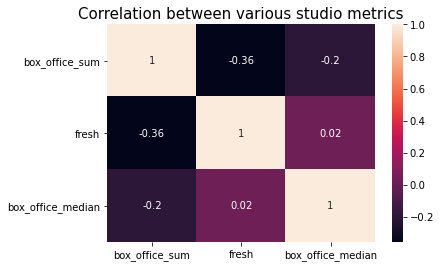

In [8]:
df = df_studios.drop('studio', axis=1)
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.title("Correlation between various studio metrics", fontsize=15)
plt.show

In [9]:
df

,movie_ct,box_office_sum,fresh,box_office_median
0,27,6.541605e+08,0.679857,19755422.0
0,36,1.171124e+09,0.464286,21045691.0
0,29,2.833732e+08,0.701482,3200000.0
0,16,2.325791e+08,0.402852,15655665.0
0,8,2.855098e+08,0.896414,27083547.5
0,18,1.768453e+08,0.624277,12711889.0
0,11,2.514614e+08,0.734409,40525262.5
0,8,9.282652e+07,0.710000,46413260.0
0,6,2.956343e+08,0.540984,71108475.0


In [10]:
##### ANALYZE DATA BY DIRECTOR #####

#Import cleanup dictionary
path = os.path.join('cleaning_dicts','cleaning_lookup_rt_directors.csv')
director_cleanup_df = pd.read_csv(path)
DIRECTOR_CLEANUP_DICT = dict(zip(director_cleanup_df.old, director_cleanup_df.new))

#Apply cleaning dictionary
director = df_rt_relevant['director']
df_rt_relevant['director'] = director.map(DIRECTOR_CLEANUP_DICT).fillna(director)

director_counts_dict = {}
directors = df_rt_relevant['director'].loc[df_rt_relevant['director'].isna()==False]
for name in directors:
    for name_split in name.split(sep = '|'):
        if name_split in director_counts_dict.keys():
            director_counts_dict[name_split] += 1
        else:
            director_counts_dict[name_split] = 1

director_counts_df = pd.Series(director_counts_dict).sort_values(ascending=False)

director_counts_df

Steven Spielberg      10
Clint Eastwood         8
William Friedkin       4
Jim Jarmusch           4
Bruce Beresford        4
                      ..
Xie Jin                1
Eleanor Burke          1
Ron Eyal               1
Philip Goodhew         1
Melvin Van Peebles     1
Length: 1214, dtype: int64

In [14]:
def clean_from_external_dict(path, series):
    df = pd.read_csv(path)
    cleaning_dict = dict(zip(df.old, df.new))
    x = df_rt_relevant['writer']
    return series.map(cleaning_dict).fillna(series)
    
    #df_rt_relevant['writer'] = writer.map(WRITER_CLEANUP_DICT).fillna(writer)
    
    
path = os.path.join('cleaning_dicts','cleaning_lookup_rt_writers.csv')
series = df_rt_relevant['writer']


temp = clean_from_external_dict(path, series).sort_values(ascending=False).reset_index(drop=True)

#print(temp[0])
#for i in ra7nge(1550):
#     print(temp[i])
    #print(df_rt_relevant['writer'][i])

#series.sort_values(ascending=False)


1131                       Zeresenay Berhane Mehari
895                                 Zenzo Matsumura
1410                          Zak Penn|Ernest Cline
604     Yoji Yamada|Ichiro Yamamoto|Emiko Hiramatsu
1174                                    Yoav Shamir
                           ...                     
1549                                           None
1553                                           None
1554                                           None
1555                                           None
1557                                           None
Name: writer, Length: 1560, dtype: object

In [11]:
##### CLEANUP WRITER DATA #####
path = os.path.join('cleaning_dicts','cleaning_lookup_rt_writers.csv')

clean_data(path)
writer_cleanup_df = pd.read_csv(path)
WRITER_CLEANUP_DICT = dict(zip(writer_cleanup_df.old, writer_cleanup_df.new))

writer = df_rt_relevant['writer']
df_rt_relevant['writer'] = writer.map(WRITER_CLEANUP_DICT).fillna(writer)

writer_counts_dict = {}
writers = df_rt_relevant.writer.loc[df_rt_relevant.writer.isna()==False]
for writer in writers:
    for writer_split in writer.split(sep = '|'):
        if writer_split in writer_counts_dict.keys():
            writer_counts_dict[writer_split] += 1
        else:
            writer_counts_dict[writer_split] = 1

writer_counts_df = pd.Series(writer_counts_dict).sort_values(ascending=False)


# df_rt_relevant['writer'] = df_rt_relevant['writer'].map(WRITER_CLEANUP_DICT).fillna(df_rt_relevant['writer'])
# df_rt_relevant

writer_counts_df.loc[writer_counts_df>2]

df_rt_relevant

,id,rating,genre,director,writer,theater_date,dvd_date,box_office,runtime,studio,fresh
0,1,R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,104 minutes,NaN,NaN
1,3,R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",600000.0,108 minutes,NaN,0.631902
2,5,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,116 minutes,NaN,0.782609
3,6,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,128 minutes,NaN,0.561404
4,7,NR,Drama|Romance,Rodney Bennett,Giles Cooper,None,None,NaN,200 minutes,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1555,1996,R,Action and Adventure|Horror|Mystery and Suspense,None,None,"Aug 18, 2006","Jan 2, 2007",33886034.0,106 minutes,NaN,0.671329
1556,1997,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993","Apr 17, 2001",NaN,88 minutes,Paramount,0.357143
1557,1998,G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,None,"Jan 1, 1962","May 11, 2004",NaN,111 minutes,NaN,NaN
1558,1999,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993","Jan 29, 2002",NaN,101 minutes,NaN,0.586957


<BarContainer object of 10 artists>

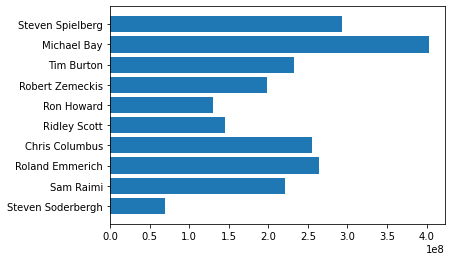

In [12]:
df_tn_top_directors = pd.read_csv('data/tn.top_directors.csv', encoding= 'unicode_escape')

MIN_MOVIE_CT = 15
MEDIAN_AVG_BOX_OFFICE = df_tn_top_directors.average.quantile(0.3) #value used to collect top 10 directors
OUT_OF_SERVICE = ['Clint Eastwood']

for i, director in enumerate(OUT_OF_SERVICE):
    index_director = df_tn_top_directors.loc[df_tn_top_directors.name==OUT_OF_SERVICE[i]].index
    df_tn_top_directors.drop(index=index_director, inplace=True)
    
    
df_tn_top_directors = df_tn_top_directors.loc[(df_tn_top_directors.movies>=MIN_MOVIE_CT) &
                        (df_tn_top_directors.average>=MEDIAN_AVG_BOX_OFFICE)].iloc[0:10].sort_values(by='worldwide_box_office')

df_tn_top_directors
plt.barh(df_tn_top_directors.name, df_tn_top_directors.average)

In [13]:
df_rt_relevant

,id,rating,genre,director,writer,theater_date,dvd_date,box_office,runtime,studio,fresh
0,1,R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,104 minutes,NaN,NaN
1,3,R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",600000.0,108 minutes,NaN,0.631902
2,5,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,116 minutes,NaN,0.782609
3,6,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,128 minutes,NaN,0.561404
4,7,NR,Drama|Romance,Rodney Bennett,Giles Cooper,None,None,NaN,200 minutes,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1555,1996,R,Action and Adventure|Horror|Mystery and Suspense,None,None,"Aug 18, 2006","Jan 2, 2007",33886034.0,106 minutes,NaN,0.671329
1556,1997,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993","Apr 17, 2001",NaN,88 minutes,Paramount,0.357143
1557,1998,G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,None,"Jan 1, 1962","May 11, 2004",NaN,111 minutes,NaN,NaN
1558,1999,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993","Jan 29, 2002",NaN,101 minutes,NaN,0.586957


In [14]:
TESTER = df.head(7)
TESTER

,box_office_median,movie_ct,box_office_sum,fresh
0,19755422.0,27,6.541605e+08,0.679857
0,21045691.0,36,1.171124e+09,0.464286
0,3200000.0,29,2.833732e+08,0.701482
0,15655665.0,16,2.325791e+08,0.402852
0,27083547.5,8,2.855098e+08,0.896414
0,12711889.0,18,1.768453e+08,0.624277
0,40525262.5,11,2.514614e+08,0.734409


<function matplotlib.pyplot.show(*args, **kw)>

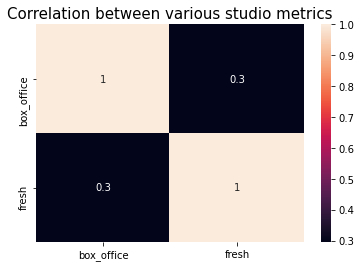

In [15]:
df = df_rt_relevant[['id', 'genre', 'box_office', 'fresh']].dropna().reset_index(drop=True)
TESTER = df.head(7)


QUANTILE = 0
df = df.loc[(df.box_office >= df.box_office.quantile(QUANTILE)) & (df.box_office <= df.box_office.quantile(1-QUANTILE))].copy()
df = df.loc[(df.fresh >= df.fresh.quantile(QUANTILE)) & (df.fresh <= df.fresh.quantile(1-QUANTILE))].copy()


rt_drop = ['Adult', 'Crime', 'Documentary', 'Drama', 'Game-Show', "Reality-TV", 'Short', 'Sport', 'Talkshow', 'Thriller', 'War']

for droppable in rt_drop:
    or_list = []
    for g in df.genre:
        split = g.split('|')
        #print('split: ',split)
        or_func = False
        for s in split:
            #print(f'{droppable} in {s}: ',droppable in s)
            or_func = or_func or (droppable in s)
        #print('OR FUNCTION: ', or_func)
        or_list.append(or_func)
    #print('OR LIST: ', or_list)
        
    #ESTER.loc[]
    df = df.drop(df[or_list].index)
    #print('------------------------------ NEXT LINE -----------------------------')
    
#TESTER.drop(index = or_list, axis=0)
    
    
#df.drop(df[df['c3'] == False].index, inplace=True)
    
df#[or_list]
x = df.fresh
y = df.box_office
# use the function regplot to make a scatterplot
sns.regplot(x,y)
#sns.plt.show()
 
# # Without regression fit:
# #sns.regplot(x=df["sepal_length"], y=df["sepal_width"], fit_reg=False)
# #sns.plt.show()


# #df_rt_relevant.genre
# df_genres.columns

# imdb_drop_4_profit = ['Crime', 'Reality_tv', 'Western', 'Sport', 'Drama', 'Thriller']
# imdb_drop_4_pop = ['Adult', 'Gameshow', 'War', 'Talkshow', 'Documentary', 'Short']
# imdb_drop = imdb_drop_4_profit + imdb_drop_4_pop
# imdb_drop



#df = df_studios.drop('studio', axis=1)
corrMatrix = df[['box_office', 'fresh']].corr()
sns.heatmap(corrMatrix, annot=True)
plt.title("Correlation between various studio metrics", fontsize=15)
plt.show

# definition of low/medium/high correlation:
# https://www.andrews.edu/~calkins/math/edrm611/edrm05.htm

In [16]:
df_genres.columns

Index(['tconst', 'primary_title', 'Action', 'Adult', 'Adventure', 'Animation',
       'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'Game-Show', 'History', 'Horror', 'Music', 'Musical',
       'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport',
       'Talk-Show', 'Thriller', 'War', 'Western'],
      dtype='object')

In [20]:
##### CURRENTLY UNUSED #####

genre_counts = {}
for item in df_rt_movie_info.genre.loc[df_rt_movie_info.genre.isna()==False]:
    for sub_item in item.split(sep = '|'):
        if sub_item in genre_counts.keys():
            genre_counts[sub_item] += 1
        else:
            genre_counts[sub_item] = 1
genre_counts = pd.Series(genre_counts).sort_values(ascending=False)

In [5]:
##### CURRENTLY UNUSED #####

rating_counts = {}
for item in df_rt_reviews['rating_clean_alpha']:
    if item in rating_counts.keys():
        rating_counts[item] += 1
    else:
        rating_counts[item] = 1
rating_counts = pd.DataFrame(rating_counts.values(), rating_counts.keys()).reset_index()
rating_counts.columns = ['rating', 'count']
rating_counts.drop(rating_counts.loc[rating_counts.rating=='unclear'].index, inplace=True)
rating_counts = rating_counts.sort_values(by='rating', ascending=True).reset_index(drop=True)